<a href="https://colab.research.google.com/github/kacperkurowski/CE888/blob/master/Assignment/Santander-Customer-Transaction-Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 1

In [1]:
import os
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
os.environ['KAGGLE_USERNAME'] = "kacperkurowski" # username from the json file

os.environ['KAGGLE_KEY'] = "7c927dd985620db03df77b3804e71a95" # key from the json file

#Unzipping Function

In [0]:
from zipfile import ZipFile

def unzip(file_name):
  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('extracted: ',file_name)


##1.Loading Data

In [4]:
!kaggle competitions download -c santander-customer-transaction-prediction # api copied from kaggle

 98% 122M/125M [00:00<00:00, 178MB/s] 
100% 125M/125M [00:00<00:00, 196MB/s]
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
 85% 106M/125M [00:00<00:00, 223MB/s] 
100% 125M/125M [00:00<00:00, 254MB/s]


##1.Removing Files that are not used

In [5]:
!rm sample_submission.csv.zip
!ls

sample_data  test2.csv.zip  test.csv.zip  train2.csv.zip  train.csv.zip


#1.Unzipping The Files

In [8]:
unzip("/content/train.csv.zip")

extracted:  /content/train.csv.zip


##Loading the files

In [9]:
import pandas as pd

#df_test_Orig = pd.read_csv("test.csv", header = 0, sep = ',', quotechar = '"')

#print(df_test_Orig)

df_train_Orig = pd.read_csv("train.csv", header = 0, sep = ',', quotechar = '"')

print(df_train_Orig)

             ID_code  target    var_0  ...  var_197  var_198  var_199
0            train_0       0   8.9255  ...   8.5635  12.7803  -1.0914
1            train_1       0  11.5006  ...   8.7889  18.3560   1.9518
2            train_2       0   8.6093  ...   8.2675  14.7222   0.3965
3            train_3       0  11.0604  ...  10.2922  17.9697  -8.9996
4            train_4       0   9.8369  ...   9.5031  17.9974  -8.8104
...              ...     ...      ...  ...      ...      ...      ...
199995  train_199995       0  11.4880  ...   8.5326  16.6660 -17.8661
199996  train_199996       0   4.9149  ...   6.7419  15.9054   0.3388
199997  train_199997       0  11.2232  ...   8.7155  13.8329   4.1995
199998  train_199998       0   9.7148  ...  10.0342  15.5289 -13.9001
199999  train_199999       0  10.8762  ...   8.1857  12.1284   0.1385

[200000 rows x 202 columns]


##Plotting Histogram of Santander-Customer-Transaction-Prediction Train Data

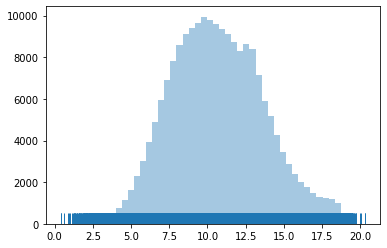

In [10]:
y_df = df_train_Orig["var_0"].copy()
y = y_df.values
sns_plot = sns.distplot(y, kde=False, rug=True)

##Plotting Histogram of Santander-Customer-Transaction-Prediction Test Data

In [11]:
#y_df = df_test_Orig["var_0"].copy()
#y = y_df.values
#sns_plot = sns.distplot(y, kde=False, rug=True)

NameError: ignored

##Adding Test Columns for testing Covariate Shift

Here i incorporate covariate shift, by placing all the data that is higher than 9.0 into the train column and everything below 9.0 into the test. 
This will cause there to be a covariate shift, as the train and test data use different data.

In [16]:
target_var = "target"
id_var = "ID_code"


df_train = df_train_Orig.where(df_train_Orig["var_0"]>9.0).dropna().drop(columns=[target_var,id_var])
df_test = df_train_Orig.where(df_train_Orig["var_0"]<=9.0).dropna().drop(columns=[target_var,id_var])
#df_train.drop(columns=['ID_code', 'target'], inplace=True)
#df_test.drop(columns=['ID_code'], inplace=True)
df_train['is_test'] = 0
df_test['is_test'] = 1
print(df_train)
print(df_test)

          var_0   var_1    var_2   var_3  ...  var_197  var_198  var_199  is_test
1       11.5006 -4.1473  13.8588  5.3890  ...   8.7889  18.3560   1.9518        0
3       11.0604 -2.1518   8.9522  7.1957  ...  10.2922  17.9697  -8.9996        0
4        9.8369 -1.4834  12.8746  6.6375  ...   9.5031  17.9974  -8.8104        0
5       11.4763 -2.3182  12.6080  8.6264  ...   9.7670  12.5809  -4.7602        0
6       11.8091 -0.0832   9.3494  4.2916  ...   9.1143  10.8869  -3.2097        0
...         ...     ...      ...     ...  ...      ...      ...      ...      ...
199994  12.3925 -5.8821  11.2323  3.9237  ...   9.1164  16.3170  -7.5048        0
199995  11.4880 -0.4956   8.2622  3.5142  ...   8.5326  16.6660 -17.8661        0
199997  11.2232 -5.0518  10.5127  5.6456  ...   8.7155  13.8329   4.1995        0
199998   9.7148 -8.6098  13.6104  5.7930  ...  10.0342  15.5289 -13.9001        0
199999  10.8762 -5.7105  12.1183  8.0328  ...   8.1857  12.1284   0.1385        0

[137385 rows x 

Classifying to Obtain 

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

#classifying to obtain AUC and ROC
def classify(df, feature):
  X = df.drop(columns=[feature]) 
  y = df[feature]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True) #Randomising nad splitting before classification
  
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_test_score = rfc.predict_proba(X_test)
  skplt.metrics.plot_roc_curve(y_test, y_test_score)
  plt.show()
  print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))
  return X,y;

Classified = pd.concat([df_train, df_test], axis = 0)
X,Y = classify(Classified, "is_test")



#df = pd.concat([df_train2, df_test2], axis = 0)
#X = df.drop(columns=['is_test'])
#y = df['is_test']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
#print('train shape:', X_train.shape, 'test shape:', X_test.shape)



##Let's use simple Random Forest as Classifier
#rfc = RandomForestClassifier()
#rfc.fit(X_train, y_train)
#y_test_score = rfc.predict_proba(X_test)



#import scikitplot as skplt
#import matplotlib.pyplot as plt

#skplt.metrics.plot_roc_curve(y_test, y_test_score)
#plt.show()


##AUC score is about 0.5
#print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))

NameError: ignored

In [0]:
pip install scikit-plot

In [0]:
##Let's use simple Random Forest as Classifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_test_score = rfc.predict_proba(X_test)

import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc_curve(y_test, y_test_score)
plt.show()


##AUC score is about 0.5
print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))